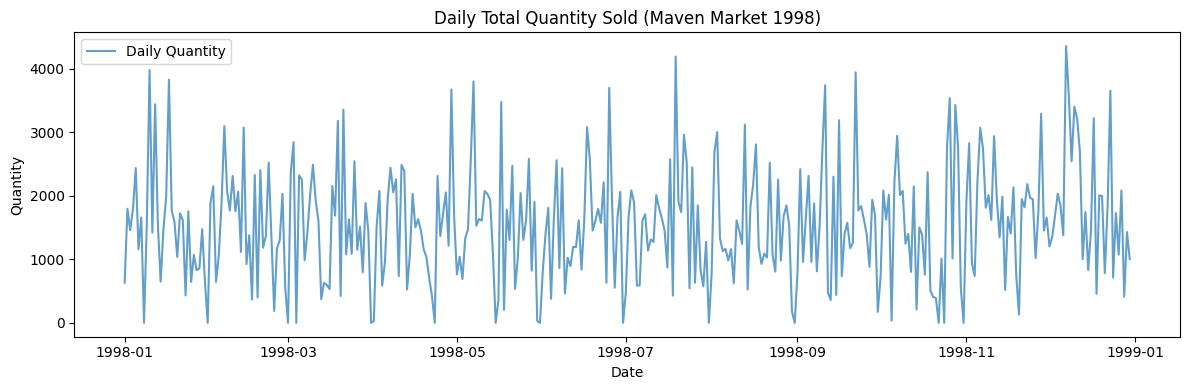

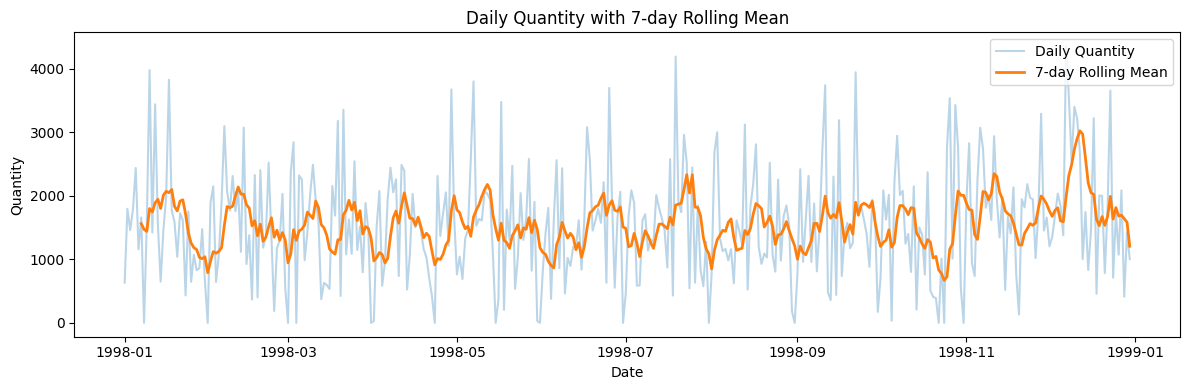

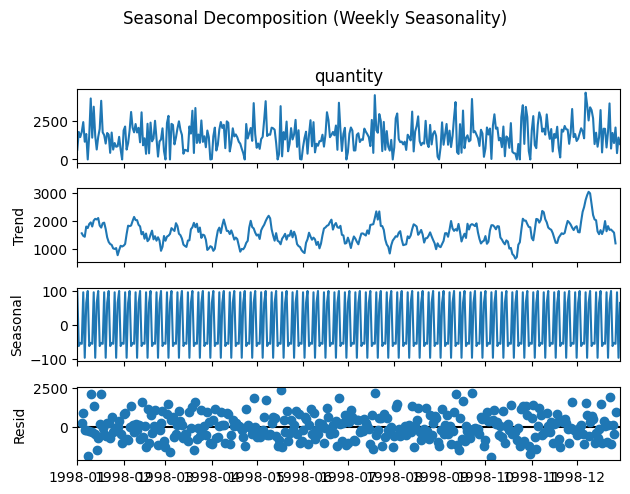

Naive Baseline:
RMSE: 1183.12
MAE : 954.07

Gradient Boosting Performance:
RMSE: 1169.71
MAE : 905.02


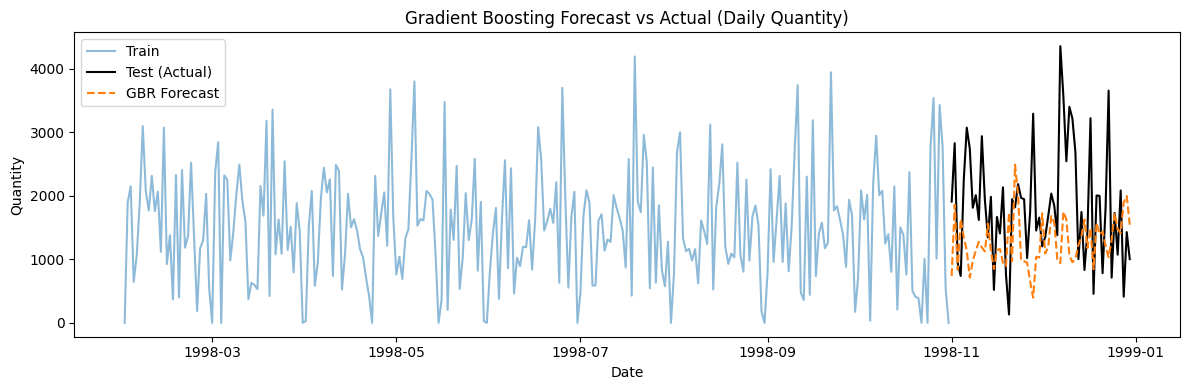


Next 30-day Forecast:
        date  forecast_quantity
0 1998-12-31        1545.447936
1 1999-01-01        1748.952280
2 1999-01-02        1347.395215
3 1999-01-03        1235.604852
4 1999-01-04         958.604640


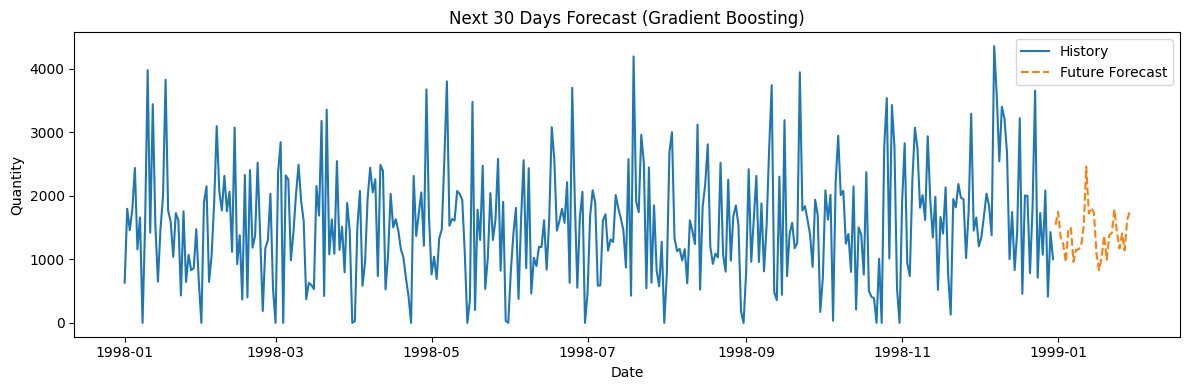

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")

df = pd.read_csv("MavenMarket_Transactions_1998.csv")

df["transaction_date"] = pd.to_datetime(df["transaction_date"])

df_daily = (
    df.groupby("transaction_date")["quantity"]
      .sum()
      .sort_index()
)

full_index = pd.date_range(start=df_daily.index.min(),
                           end=df_daily.index.max(),
                           freq="D")

daily = df_daily.reindex(full_index).fillna(0.0)
daily.index.name = "date"

plt.figure(figsize=(12, 4))
plt.plot(daily.index, daily.values, label="Daily Quantity", alpha=0.7)
plt.title("Daily Total Quantity Sold (Maven Market 1998)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()

rolling_7 = daily.rolling(window=7).mean()

plt.figure(figsize=(12, 4))
plt.plot(daily.index, daily.values, label="Daily Quantity", alpha=0.3)
plt.plot(daily.index, rolling_7.values, label="7-day Rolling Mean", linewidth=2)
plt.title("Daily Quantity with 7-day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()

decomp = seasonal_decompose(daily, model="additive", period=7)
decomp.plot()
plt.suptitle("Seasonal Decomposition (Weekly Seasonality)", y=1.02)
plt.tight_layout()
plt.show()

def create_features(series, lags=[1, 2, 7, 14], windows=[7, 30]):
    df_fe = pd.DataFrame({"y": series})
    for lag in lags:
        df_fe[f"lag_{lag}"] = df_fe["y"].shift(lag)
    for w in windows:
        df_fe[f"roll_mean_{w}"] = df_fe["y"].shift(1).rolling(w).mean()
        df_fe[f"roll_std_{w}"] = df_fe["y"].shift(1).rolling(w).std()
    df_fe["dayofweek"] = df_fe.index.dayofweek
    df_fe["month"] = df_fe.index.month
    df_fe = df_fe.dropna()
    return df_fe

supervised = create_features(daily)

test_size = 60

train = supervised.iloc[:-test_size]
test = supervised.iloc[-test_size:]

X_train = train.drop("y", axis=1)
y_train = train["y"]

X_test = test.drop("y", axis=1)
y_test = test["y"]

naive_pred = supervised["y"].shift(1).reindex(y_test.index)

naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
naive_mae = mean_absolute_error(y_test, naive_pred)

print("Naive Baseline:")
print("RMSE:", round(naive_rmse, 2))
print("MAE :", round(naive_mae, 2))

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
gbr_mae = mean_absolute_error(y_test, y_pred)

print("\nGradient Boosting Performance:")
print("RMSE:", round(gbr_rmse, 2))
print("MAE :", round(gbr_mae, 2))

plt.figure(figsize=(12, 4))
plt.plot(y_train.index, y_train, label="Train", alpha=0.5)
plt.plot(y_test.index, y_test, label="Test (Actual)", color="black")
plt.plot(y_test.index, y_pred, label="GBR Forecast", linestyle="--")
plt.title("Gradient Boosting Forecast vs Actual (Daily Quantity)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()

future_steps = 30
current_series = daily.copy()
future_index = []
future_preds = []

for step in range(future_steps):
    temp = create_features(current_series).iloc[-1:]
    X_future = temp.drop("y", axis=1)
    next_pred = gbr.predict(X_future)[0]
    next_date = current_series.index[-1] + pd.Timedelta(days=1)
    current_series = pd.concat([current_series, pd.Series([next_pred], index=[next_date])])
    future_index.append(next_date)
    future_preds.append(next_pred)

future_df = pd.DataFrame({"date": future_index, "forecast_quantity": future_preds})
print("\nNext 30-day Forecast:")
print(future_df.head())

plt.figure(figsize=(12, 4))
plt.plot(daily.index, daily.values, label="History")
plt.plot(future_df["date"], future_df["forecast_quantity"], label="Future Forecast", linestyle="--")
plt.title("Next 30 Days Forecast (Gradient Boosting)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()


SARIMA Performance:
RMSE: 967.79
MAE : 742.15


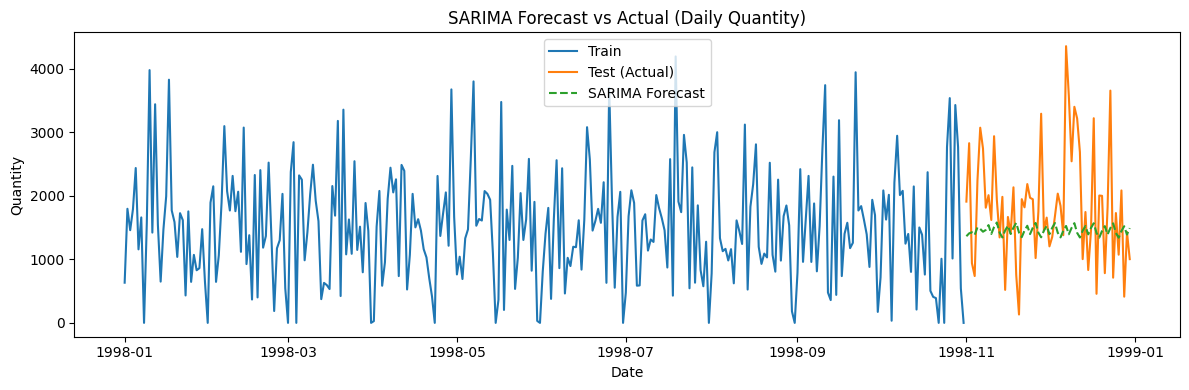


Next 30-day SARIMA Forecast:
        date  forecast_quantity
0 1998-12-31        1566.441269
1 1999-01-01        1413.763114
2 1999-01-02        1340.591197
3 1999-01-03        1445.932040
4 1999-01-04        1520.648492


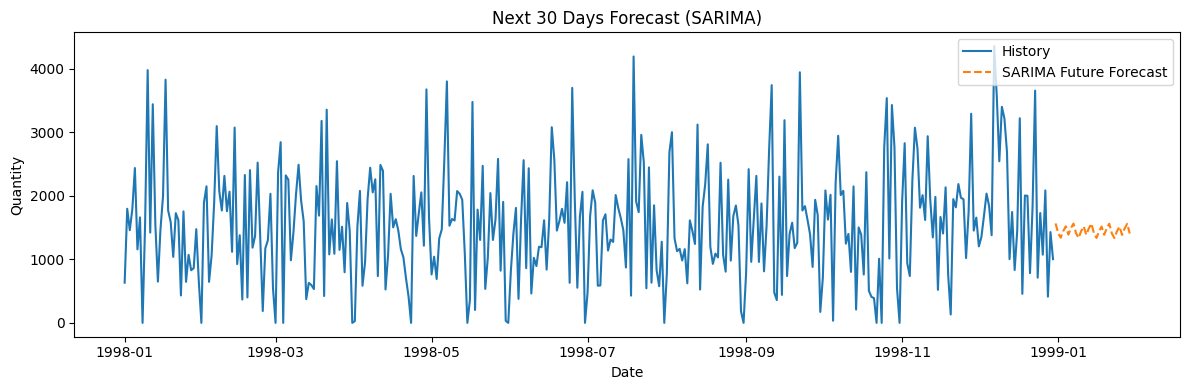

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

y = daily.copy()

test_size = 60
train = y[:-test_size]
test = y[-test_size:]

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7),
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

pred = model_fit.forecast(len(test))
pred.index = test.index

rmse = np.sqrt(mean_squared_error(test, pred))
mae = mean_absolute_error(test, pred)

print("SARIMA Performance:")
print("RMSE:", round(rmse, 2))
print("MAE :", round(mae, 2))

plt.figure(figsize=(12,4))
plt.plot(train.index, train.values, label="Train")
plt.plot(test.index, test.values, label="Test (Actual)")
plt.plot(pred.index, pred.values, label="SARIMA Forecast", linestyle="--")
plt.title("SARIMA Forecast vs Actual (Daily Quantity)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()

future_steps = 30
future_forecast = model_fit.forecast(steps=len(test) + future_steps)
future_only = future_forecast[-future_steps:]

future_dates = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1),
                             periods=future_steps, freq="D")

future_df = pd.DataFrame({"date": future_dates, "forecast_quantity": future_only.values})
print("\nNext 30-day SARIMA Forecast:")
print(future_df.head())

plt.figure(figsize=(12,4))
plt.plot(y.index, y.values, label="History")
plt.plot(future_df["date"], future_df["forecast_quantity"],
         label="SARIMA Future Forecast", linestyle="--")
plt.title("Next 30 Days Forecast (SARIMA)")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.tight_layout()
plt.show()


Brand-level performance (best to worst):
    product_brand  naive_rmse  naive_mae  gbr_rmse   gbr_mae
105          King    2.136976   1.366667  1.612485  1.230081
56        Prelude    2.652043   1.733333  2.212626  1.505686
109       Tip Top    3.945462   2.800000  2.571275  1.926369
102           ADJ    3.413210   2.316667  2.645329  1.988566
74          Akron    3.281260   2.500000  2.660113  2.016015
110      Symphony    2.089657   1.300000  2.772383  2.500468
107       Gerolli    3.701351   2.833333  2.869951  2.292890
98        Toretti    2.542964   1.466667  2.907969  2.421035
19         Curlew    3.633180   2.466667  2.927952  2.292957
99       Big City    3.495235   2.416667  3.099849  2.619704


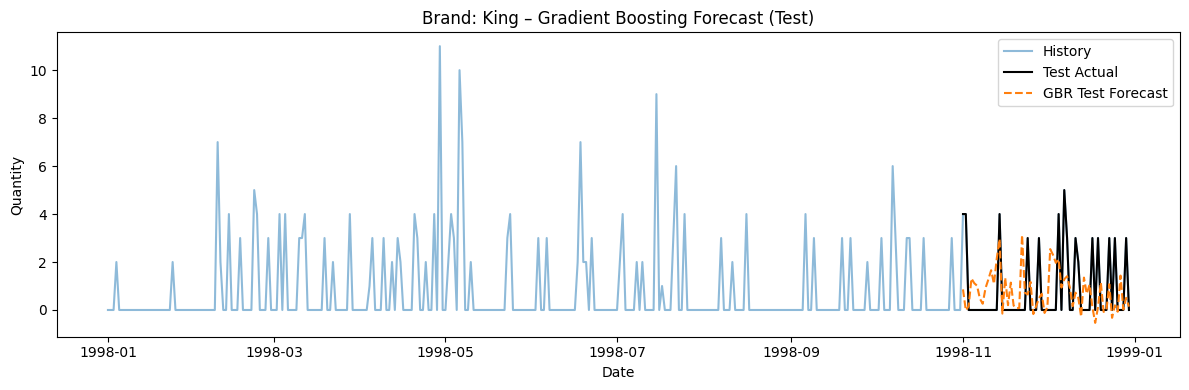

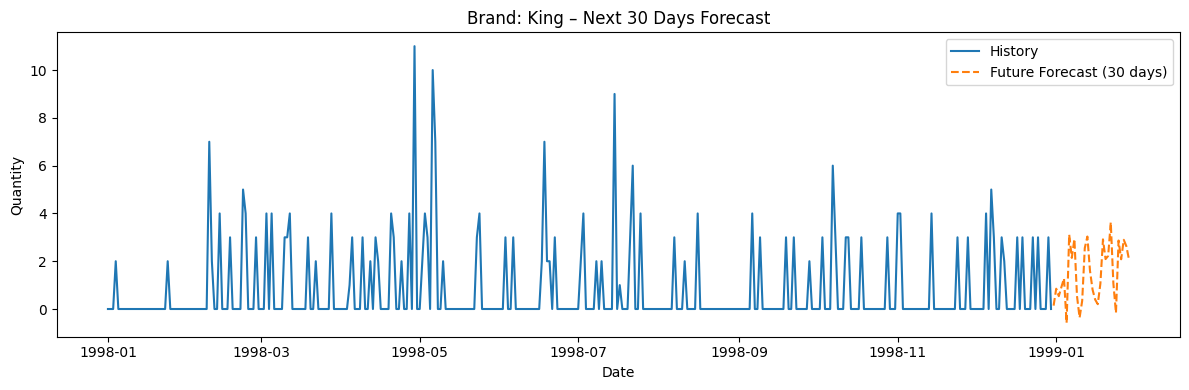

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

transactions = pd.read_csv("MavenMarket_Transactions_1998.csv")
products = pd.read_csv("MavenMarket_Products.csv")

transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])

products_trim = products[["product_id", "product_brand"]]
df = transactions.merge(products_trim, on="product_id", how="left")

brand_daily = (
    df.groupby(["transaction_date", "product_brand"])["quantity"]
      .sum()
      .sort_index()
)

all_dates = pd.date_range(
    start=brand_daily.index.get_level_values("transaction_date").min(),
    end=brand_daily.index.get_level_values("transaction_date").max(),
    freq="D"
)

brands = brand_daily.index.get_level_values("product_brand").unique()

def create_features(series, lags=[1, 2, 7, 14], windows=[7, 30]):
    df_fe = pd.DataFrame({"y": series})
    for lag in lags:
        df_fe[f"lag_{lag}"] = df_fe["y"].shift(lag)
    for w in windows:
        df_fe[f"roll_mean_{w}"] = df_fe["y"].shift(1).rolling(w).mean()
        df_fe[f"roll_std_{w}"] = df_fe["y"].shift(1).rolling(w).std()
    df_fe["dayofweek"] = df_fe.index.dayofweek
    df_fe["month"] = df_fe.index.month
    df_fe = df_fe.dropna()
    return df_fe

results = []
brand_forecasts = {}

for b in brands:
    ts = brand_daily.xs(b, level="product_brand")
    ts_full = ts.reindex(all_dates).fillna(0.0)
    ts_full.index.name = "date"
    if ts_full.sum() == 0:
        continue
    supervised = create_features(ts_full)
    if len(supervised) < 120:
        continue
    test_size = 60
    train = supervised.iloc[:-test_size]
    test = supervised.iloc[-test_size:]
    X_train = train.drop("y", axis=1)
    y_train = train["y"]
    X_test = test.drop("y", axis=1)
    y_test = test["y"]
    naive_pred = supervised["y"].shift(1).reindex(y_test.index)
    naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
    naive_mae = mean_absolute_error(y_test, naive_pred)
    gbr = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        random_state=42
    )
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    gbr_mae = mean_absolute_error(y_test, y_pred)
    results.append({
        "product_brand": b,
        "naive_rmse": naive_rmse,
        "naive_mae": naive_mae,
        "gbr_rmse": gbr_rmse,
        "gbr_mae": gbr_mae
    })
    future_steps = 30
    current_series = ts_full.copy()
    future_index = []
    future_preds = []
    for step in range(future_steps):
        temp = create_features(current_series).iloc[-1:]
        X_future = temp.drop("y", axis=1)
        next_pred = gbr.predict(X_future)[0]
        next_date = current_series.index[-1] + pd.Timedelta(days=1)
        current_series = pd.concat([current_series, pd.Series([next_pred], index=[next_date])])
        future_index.append(next_date)
        future_preds.append(next_pred)
    future_df = pd.DataFrame({"date": future_index, "forecast_quantity": future_preds})
    brand_forecasts[b] = {
        "history": ts_full,
        "test_actual": y_test,
        "test_pred": pd.Series(y_pred, index=y_test.index),
        "future_forecast": future_df
    }

results_df = pd.DataFrame(results).sort_values("gbr_rmse")
print("Brand-level performance (best to worst):")
print(results_df.head(10))

if not results_df.empty:
    example_brand = results_df.iloc[0]["product_brand"]
    bf = brand_forecasts[example_brand]
    history = bf["history"]
    test_actual = bf["test_actual"]
    test_pred = bf["test_pred"]
    future_df = bf["future_forecast"]

    plt.figure(figsize=(12, 4))
    plt.plot(history.index, history.values, label="History", alpha=0.5)
    plt.plot(test_actual.index, test_actual.values, label="Test Actual", color="black")
    plt.plot(test_pred.index, test_pred.values, label="GBR Test Forecast", linestyle="--")
    plt.title(f"Brand: {example_brand} – Gradient Boosting Forecast (Test)")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(history.index, history.values, label="History")
    plt.plot(future_df["date"], future_df["forecast_quantity"], label="Future Forecast (30 days)", linestyle="--")
    plt.title(f"Brand: {example_brand} – Next 30 Days Forecast")
    plt.xlabel("Date")
    plt.ylabel("Quantity")
    plt.legend()
    plt.tight_layout()
    plt.show()
